In [1]:
import sys
sys.path.append('..')

## Load Data

In [2]:
import wfdb
from raccoon.utils.annotationutils import trigger_points

def read_record(path, sampto=None):
    record = wfdb.rdrecord(path, sampto=sampto)
    annotation = wfdb.rdann(path, 'atr', sampto=sampto)
    trigger = trigger_points(annotation)
    return record, trigger

def read_records(directory, names, sampto=None):
    records, triggers = [], []
    for name in names:
        path = "/".join([directory, name])
        record, trigger = read_record(path, sampto)
        records.append(record)
        triggers.append(trigger)
    return records, triggers

In [3]:
import numpy as np

signal_dir = "../data/mitdb"
names = np.array([
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109"
])
sampto = 10000

records, triggers = read_records(signal_dir, names, sampto)
records, triggers = np.array(records), np.array(triggers)

## Create Detectors

In [4]:
from raccoon.detectors import XiangDetector

xd = XiangDetector(
    name="XD",
    window_size=60,
    detection_size=20,
    batch_size=32,
    aux_ratio=5,
    epochs=3)

Using TensorFlow backend.


## Train and Test

In [5]:
from contextlib import redirect_stdout
from copy import deepcopy
from io import StringIO
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()
ts_originals, ts_flippeds = [], []

for step_id, (train_indexes, test_indexes) in enumerate(cv.split(names), start=1):
    print("Step {}/{}: {}".format(step_id, cv.get_n_splits(names), test_indexes))

    train_records = records[train_indexes]
    train_triggers = triggers[train_indexes]
    xd.reset()
    with redirect_stdout(StringIO()):
        xd.train(train_records, train_triggers)
    
    test_record = records[test_indexes][0]
    test_record_flipped = deepcopy(test_record)
    test_record_flipped.p_signal = -test_record_flipped.p_signal
    test_trigger = triggers[test_indexes][0]
    ts_originals.append(xd.trigger_signal(test_record))
    ts_flippeds.append(xd.trigger_signal(test_record_flipped))

Step 1/10: [0]
Step 2/10: [1]
Step 3/10: [2]
Step 4/10: [3]
Step 5/10: [4]
Step 6/10: [5]
Step 7/10: [6]
Step 8/10: [7]
Step 9/10: [8]
Step 10/10: [9]


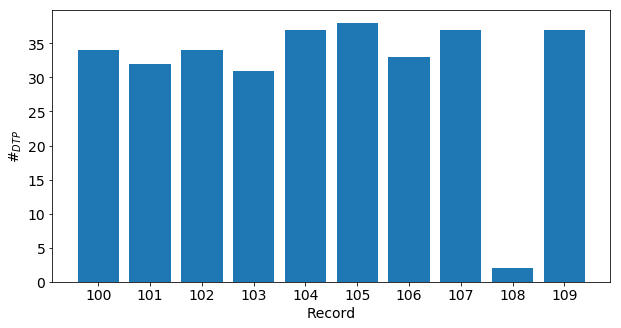

In [6]:
from raccoon.utils.triggerutils import signal_to_points
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

nqrs_originals = [
    len(signal_to_points(ts))
    for ts in ts_originals]

nqrs_fig, nqrs_ax = plt.subplots()
nqrs_fig.set_size_inches(10,5)

nqrs_ax.bar(range(100, 110), nqrs_originals)
nqrs_ax.set_ylabel(r"$\#_{DTP}$")
nqrs_ax.set_xlabel("Record")
nqrs_ax.set_xticks(range(100, 110))

plt.show()

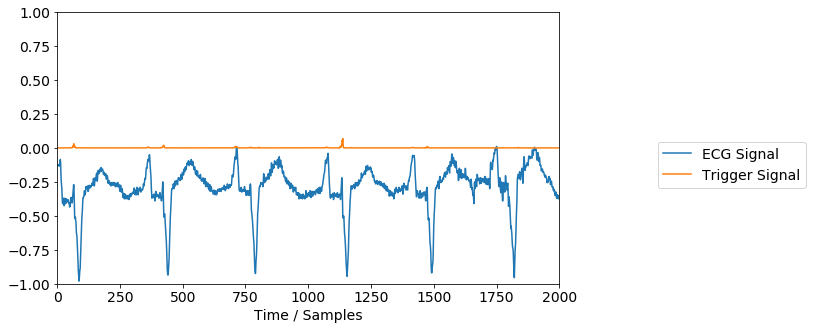

In [7]:
# From here on focus on Record 108 only:
idx = 8

r8o_fig, f8o_ax = plt.subplots()
r8o_fig.set_size_inches(12,5)

f8o_ax.plot(records[idx].p_signal.T[0], label="ECG Signal")
f8o_ax.plot(ts_originals[idx], label="Trigger Signal")
f8o_ax.set_xlim(0,2000)
f8o_ax.set_ylim(-1, 1)
f8o_ax.set_xlabel("Time / Samples")

# Shrink current axis by 25%
box = f8o_ax.get_position()
f8o_ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

# Put a legend to the right of the current axis
r8o_fig.legend(loc='center right')

plt.show()

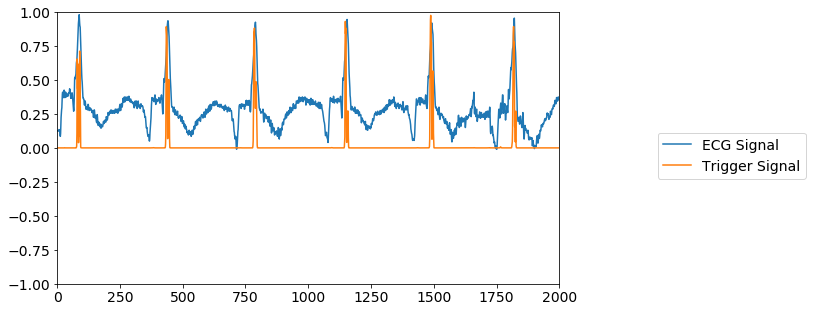

In [8]:
flipped_record = deepcopy(records[idx])
flipped_record.p_signal = -flipped_record.p_signal

r8f_fig, f8f_ax = plt.subplots()
r8f_fig.set_size_inches(12,5)

f8f_ax.plot(flipped_record.p_signal.T[0], label="ECG Signal")
f8f_ax.plot(ts_flippeds[idx], label="Trigger Signal")
f8f_ax.set_xlim(0,2000)
f8f_ax.set_ylim(-1, 1)
f8o_ax.set_xlabel("Time / Samples")

# Shrink current axis by 25%
box = f8f_ax.get_position()
f8f_ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

# Put a legend to the right of the current axis
r8f_fig.legend(loc='center right')

plt.show()

In [9]:
from raccoon.utils.triggerutils import signal_to_points
from raccoon.utils.evaluationutils import trigger_metrics, sensitivity, ppv, f1

tp_original = signal_to_points(ts_originals[idx], threshold=0.3)
tp_flipped = signal_to_points(ts_flippeds[idx], threshold=0.3)

tpo, tno, fpo, fno = trigger_metrics(triggers[idx], tp_original, 5)
tpf, tnf, fpf, fnf = trigger_metrics(triggers[idx], tp_flipped, 5)

ses_o = sensitivity(tpo, fno)
ses_f = sensitivity(tpf, fnf)
ppv_o = ppv(tpo, fpo)
ppv_f = ppv(tpf, fpf)
f1_o = f1(tpo, fpo, fno)
f1_f = f1(tpf, fpf, fnf)

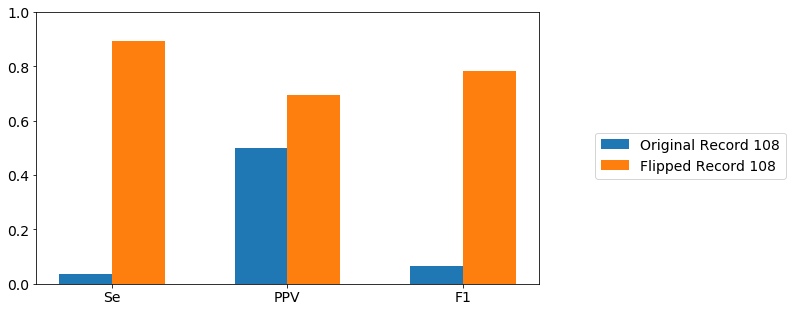

In [10]:
comp_fig, comp_ax = plt.subplots()
comp_fig.set_size_inches(12, 5)

bar_width = 0.3
index = np.arange(3) # Se, PPV, F1

comp_ax.bar(index, (ses_o, ppv_o, f1_o), bar_width, label="Original Record 108")
comp_ax.bar(index+bar_width, (ses_f, ppv_f, f1_f), bar_width, label="Flipped Record 108")

comp_ax.set_xticks(index + 0.5*bar_width)
comp_ax.set_xticklabels(('Se', 'PPV', 'F1'))
comp_ax.set_ylim(0, 1)

# Shrink current axis by 25%
box = comp_ax.get_position()
comp_ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

# Put a legend to the right of the current axis
comp_fig.legend(loc='center right')

plt.show()

In [12]:
save = False

if save:
    nqrs_fig.savefig(
        '../../msc-thesis/thesis/images/num_qrs_per_record.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0)
    r8o_fig.savefig(
        '../../msc-thesis/thesis/images/record_108_original.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0)
    r8f_fig.savefig(
        '../../msc-thesis/thesis/images/record_108_flipped.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0)
    comp_fig.savefig(
        '../../msc-thesis/thesis/images/heart_axis_adjustment_comparison.pdf',
        format='pdf',
        bbox_inches = 'tight',
        pad_inches = 0)